In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from reweight_functions import *
import pickle

In [3]:
# starting by importing the weighting/reweighting information + making directories to store all the info 

main_path = '/Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Final_Project/Alanine_Mutant/'

outdir = os.path.join(main_path, 'reweight_trial')
datadir = main_path
expdatadir = main_path
weights_dir = os.path.join(outdir, 'weights')

if not os.path.exists(outdir):
    os.makedirs(outdir)
if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)

single_dir = os.path.join(weights_dir + "/single_data")
if not os.path.exists(single_dir):
    os.makedirs(single_dir)
leave_dir = os.path.join(weights_dir + "/leave_one_data")
if not os.path.exists(leave_dir):
    os.makedirs(leave_dir)
combined_dir = os.path.join(weights_dir + "/combined_data")
if not os.path.exists(combined_dir):
    os.makedirs(combined_dir)

dic_dir = os.path.join(outdir, 'dictionaries')
if not os.path.exists(dic_dir):
    os.makedirs(dic_dir)

In [4]:
# now we're going to define some arrays and dictionaries that can work withthe CSP/backbone data 
# since we're looking at the secondary structure, we primarily care about the CA! and other impt backbone atoms, like C'
# and with reweighting, we only have important data for CA and C', which is why we're keeping those keys from the dictionary for reweighting
chemical_shifts = ['CB', 'CA', 'H', 'N', 'C']

colors = {'C': 'royalblue', 'HA': 'orange', 'CA': 'red', 'CB': 'forestgreen', 'H': 'mediumorchid',
            'N': 'darkslateblue', 'JHNHA': 'cornflowerblue', 'Rg': 'grey', 'CD': 'firebrick', 'SAXS': 'teal',
            'Tot': 'black'}

reweighting_keys = ['CA', 'C', 'CD']
theta_0 = {'HA': 1., 'CA': 1, 'CB': 1., 'C': 1., 'H': 1., 'HA2': 1., 'HA3': 1., 'N': 1., 'RDC': 1., 'Rg': 1.,
            'JHNHA': 1., 'SAXS': 1., 'CD': 1.}

to_remove = ['HA','HA2', 'HA3', 'CB', 'H', 'N']

print('Main settings:\n')
print('Reweighting keys: {}'.format(reweighting_keys))

Main settings:

Reweighting keys: ['CA', 'C', 'CD']


In [5]:
# let's import the chemical shift data to work with 
expdata = read_exp_cs(join(expdatadir, 'CS.exp.dat'))
compdata = read_cs_md(join(datadir, 'cs_assignment.csv'), )

In [6]:
# this function is adjusting the number to keys, specifcally in R2 and R3 which are the helical regions in Tau-5 
# adjusted dictionary with fixed residue numbers is returned 

def adjust_and_clean_keys(nested_dict, add_value=390, keys_to_remove=['390', '447']):
    new_dict = {}
    for shift_type, shifts in nested_dict.items():
        adjusted_shifts = {str(int(k) + add_value): v for k, v in shifts.items()}
        # Remove specified keys
        for key in keys_to_remove:
            if key in adjusted_shifts:
                del adjusted_shifts[key]
        new_dict[shift_type] = adjusted_shifts
    return new_dict


# this function is using the function from above to realign the numbers 
# then we are iterating over both the simulation and experimental data to find keys that should be realigned
# only keys that are present in both are kept 
# makes sense we have to do this since not every single residue had a chemical shift that could be calculated (due to noise/overlap)
# or, with CD data, we can match up wavelengths 

def Align_Comp_Exp_Data(compdata, expdata):
    # Adjust and clean keys in compdata only
    compdata = adjust_and_clean_keys(compdata)

    for data1, data1_t in zip([compdata, expdata], ['comp', 'exp']):
        data2 = expdata if data1_t == 'comp' else compdata
        to_align = {}
        for key1 in data1.keys():
            to_align[key1] = []
            for key2 in data1[key1].keys():
                if key2 not in data2[key1].keys() or data1[key1][key2][0] == 0.0:
                    to_align[key1].append(key2)

        for key1 in to_align.keys():
            for key2 in to_align[key1]:
                if key2 in data1[key1].keys():
                    data1[key1].pop(key2)
                if key2 in data2[key1].keys():
                    data2[key1].pop(key2)
                  
    return compdata, expdata

In [7]:
# Elimination of compdata that are not in expdata and viceversa
compdata, expdata = Align_Comp_Exp_Data(compdata, expdata)

# defining the CD data variables for experimental and computed 
expdata = add_exp_data(join(expdatadir, 'CD.exp.dat'), expdata, 'CD')
compdata = add_md_data(join(datadir, 'CD.csv'), compdata, 'CD')

# a function that converts numbers to strings to work with as we analyze/pull in data and reweight 
def convert_keys_to_str(d):
    new_dict = {}
    for key, value in d.items():
        # Convert the key to float to remove trailing zeros
        new_key = float(key)
        # Convert the float key back to string
        new_key_str = str(new_key)
        # Add the new key-value pair to the new dictionary
        new_dict[new_key_str] = value
    return new_dict

# Apply the function to the 'CD' key
compdata['CD'] = convert_keys_to_str(compdata['CD'])
expdata['CD'] = convert_keys_to_str(expdata['CD'])
####### TRAJ-related quantities

nframes = len(compdata[list(compdata.keys())[1]][list(compdata[list(compdata.keys())[1]].keys())[0]])
# nframes = len(compdata['Rg'][0])

# labels
exp_labels = list(compdata.keys())
true_exp_labels = [key for key in exp_labels if key not in to_remove]

print(
    'Correctely acquired data from experiments and for MD simulations for the following quantities:\n{}\nNumber of frames = {}'.format(
        [str(key) for key in compdata.keys()], nframes))

Correctely acquired data from experiments and for MD simulations for the following quantities:
['HA', 'CA', 'CB', 'C', 'H', 'HA2', 'HA3', 'N', 'CD']
Number of frames = 3211


In [8]:
# and now with the data imported, we can reweight 

sd = {}
To_Scan = reweighting_keys
for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
    print('Reweight Data = {}'.format(CS))
    print('Validation Data = {}'.format(Validation_Data))

    ### debugging variables in case something goes wrong 
    compare = []
    compare_dict_r = {key: {} for key in compdata.keys()}
    compare_dict_v = {key: {} for key in compdata.keys()}

    ####### The reweighting procedure

    # i) Process Reweight data into arrays 
    obs_exp_r, traj_r, err_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays(Reweight_Data,
                                                                                                expdata, compdata,
                                                                                                theta_0,
                                                                                                compare_dict_r)

    # ii) Process Validation data into arrays 
    obs_exp_v, traj_v, err_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays(Validation_Data,
                                                                                                expdata, compdata,
                                                                                                theta_0,
                                                                                                compare_dict_v)

    # final_weights
    # calculating the weights using validating data (whats being used to check that these new predictions make sense) 
    for key in data_v_type:
        print(key)
        res = []
        md_ave = []
        sigmas = []
        exp = []
        sd[key] = {}
        for key2 in compare_dict_v[key]:
            timeseries = compare_dict_v[key][key2][1]
            uniform_weights = np.ones(len(timeseries))
            dim = 5000
            A, W = Weighted_Independent_Blocks(timeseries, uniform_weights, dim, verbose=False)
            ave = np.average(A, weights=W)
            sigma = Weighted_Sigma_of_Mean(A, W)
            sd[key][key2] = np.array([float(key2), float(compare_dict_v[key][key2][0]), float(ave), float(sigma)])

    # calculating the weights for reweight data (whats being used to change the prediction based on frames that were impt in experiments) 
    for key in data_r_type:
        print(key)
        res = []
        md_ave = []
        sigmas = []
        exp = []
        sd[key] = {}
        for key2 in compare_dict_r[key]:
            timeseries = compare_dict_r[key][key2][1]
            uniform_weights = np.ones(len(timeseries))
            dim = 5000
            A, W = Weighted_Independent_Blocks(timeseries, uniform_weights, dim, verbose=False)
            ave = np.average(A, weights=W)
            sigma = Weighted_Sigma_of_Mean(A, W)
            sd[key][key2] = np.array([float(key2), float(compare_dict_r[key][key2][0]), float(ave), float(sigma)])

Reweight Data = CA
Validation Data = ['C', 'CD']
C
CD
CA
Reweight Data = C
Validation Data = ['CA', 'CD']
CA
CD
C
Reweight Data = CD
Validation Data = ['CA', 'C']
CA
C
CD


## In the cells below, we're going to reweight our data using different parameters. We can reweight with backbone CA and C' data or CD data, or reweight with both. Each set will result in different prediction quality as both sets of data are through different experimental methods

In [9]:
#biiiig code block that accomplishes the following things:
# extract the info we need for reweighting (ie experimental data for CA and makes a dictionary that can compare the reweight and validation processes) 
# reweight! uses the reweight data and the validation data through a parameter of "thetas", which essentially makes a loop 
#that can adjust data based on the parameter and calculate the Kish ratio (so we can check how well the reweighting is working), and then the RMSE so we can compare the computed data with experimental)  

To_Scan = reweighting_keys
thetas = np.linspace(0.001, 20, 200)
ref_theta = thetas[-1]
RMSE_dict = {}
KishScan_one_data = {}
#also defining kish scores (which are used to make sure that the reweighting/simulation isn't preferring one frame over all others, helps make sure we have an accurate prediction system)

for CS in To_Scan:
        CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
        KishScan_one_data[CS] = {}
        print('Reweight Data = {}'.format(CS))
        RMSE_dict[CS] = {}

        ### debugging variables
        compare = []
        compare_dict_r = {key: {} for key in compdata.keys()}
        compare_dict_v = {key: {} for key in compdata.keys()}

        ####### B) The reweighting procedure

        obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(
            Reweight_Data, expdata, compdata, theta_0, sd, compare_dict_r)
        obs_exp_v, traj_v, err_v, sigma_md_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays_with_sigma(
            Validation_Data, expdata, compdata, theta_0, sd, compare_dict_v)

        # THETA CYCLE - used to look at how different settings can affect the reweighting
        # iterate over calculations for reweighting
        # use theta_m value to adjust parameters 
    
        # store values 
        theta_list = []
        kish_list = []
        rmsd_f_list = []
        for theta_m in np.flip(thetas):

            s = '{:.2f}'.format(theta_m)
            # print(s)
            sigma_reg = theta_m * err_r
            sigma_md = sigma_md_r
            RMSE_dict[CS][s] = {}

            # iv) Print dimensions
            nobs_r = len(obs_exp_r)
            nobs_v = len(obs_exp_v)
            # Print_Number_of_Data(nframes, nobs_r, nobs_v, data_r_type, data_v_type)

            # v) perform minimization. We want smaller kish scores (suggests that the simulation/reweighted simulation is looking at frames equally
            # a high kish score might suggest that the simulation is prefering one frame over others when it should be considering frames equally or according to the reweighting parameters introduced by the data
            # OBS: res.X = lagrange multiplier
            weight_bias = np.ones(nframes)

            if 'RDC' in Reweight_Data:
                initial_weights = weight_bias
                initial_weights /= np.sum(initial_weights)
                initial_obs_r = np.dot(traj_r, initial_weights)
                initial_obs_r
                exp_rdc = np.trim_zeros(obs_exp_r * data_r_type['RDC'])
                calc_rdc = np.trim_zeros(initial_obs_r * data_r_type['RDC'])
                qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
                qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

                if (qf_neg < qf_pos):
                    c = -c_neg
                else:
                    c = c_pos

                RDC_rows = np.where(data_r_type['RDC'] == 1)
                traj_r[RDC_rows] = traj_r[RDC_rows] * c

            if 'RDC' in Validation_Data:
                initial_weights = weight_bias
                initial_weights /= np.sum(initial_weights)
                initial_obs_v = np.dot(traj_v, initial_weights)
                exp_rdc = np.trim_zeros(obs_exp_v * data_v_type['RDC'])
                calc_rdc = np.trim_zeros(initial_obs_v * data_v_type['RDC'])
                qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
                qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

                if (qf_neg < qf_pos):
                    c = -c_neg
                else:
                    c = c_pos

                RDC_rows = np.where(data_v_type['RDC'] == 1)
                traj_v[RDC_rows] = traj_v[RDC_rows] * c

            res = sp.optimize.minimize(func_sigma_reg_sigma_md,
                                       args=(traj_r, obs_exp_r, weight_bias, sigma_reg, sigma_md),
                                       x0=np.zeros((nobs_r,)), method='L-BFGS-B', jac=True)
            initial_weights = Normalize_Weights(weight_bias)
            initial_obs_r = np.dot(traj_r, initial_weights)
            initial_obs_v = np.dot(traj_v, initial_weights)

            final_weights = Normalize_Weights(weight_bias - np.dot(res.x, traj_r))
            final_obs_r = np.dot(traj_r, final_weights)
            final_obs_v = np.dot(traj_v, final_weights)
            # g) calculating Kish effective size
            Ks_b = np.average(initial_weights) ** 2 / np.average(initial_weights ** 2)
            Ks_a = np.average(final_weights) ** 2 / np.average(final_weights ** 2)

            Kish_ratio = (Ks_a / Ks_b) * 100
            RMSE_initial = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))
            RMSE_reweight = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))

            theta_list.append(theta_m)
            kish_list.append(Kish_ratio)
            rmsd_f_list.append(RMSE_reweight)
            RMSE_r_i = {}
            RMSE_v_i = {}
            RMSE_r_f = {}
            RMSE_v_f = {}
            RMSE_r_i['Tot'] = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))

            for t in data_r_type:
                RMSE_r_i[t] = np.sqrt(
                    np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
                if str(t) == 'RDC':
                    qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
                                                                       obs_exp_r * data_r_type['RDC'])
                    RMSE_r_i['RDC'] = qf

            RMSE_v_i['Tot'] = np.sqrt(
                np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
            for t in data_v_type:
                RMSE_v_i[t] = np.sqrt(
                    np.sum((initial_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t]))
                if str(t) == 'RDC':
                    qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_v * data_v_type['RDC'],
                                                                       obs_exp_v * data_v_type['RDC'])
                    RMSE_v_i['RDC'] = qf

            RMSE_r_f['Tot'] = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))

            for t in data_r_type:
                RMSE_r_f[t] = np.sqrt(np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
                if str(t) == 'RDC':
                    qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
                                                                       obs_exp_r * data_r_type['RDC'])
                    RMSE_r_f['RDC'] = qf

            for t in data_v_type:
                RMSE_v_f[t] = np.sqrt(np.sum((final_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t]))
                if str(t) == 'RDC':
                    qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(final_obs_v * data_v_type['RDC'],
                                                                       obs_exp_v * data_v_type['RDC'])
                    RMSE_v_f['RDC'] = qf

            RMSE_dict[CS][s]['Kish'] = Kish_ratio
            RMSE_dict[CS][s]['r_i'] = RMSE_r_i
            RMSE_dict[CS][s]['r_f'] = RMSE_r_f
            RMSE_dict[CS][s]['v_i'] = RMSE_v_i
            RMSE_dict[CS][s]['v_f'] = RMSE_v_f

        KishScan_one_data[CS]['kish'] = np.column_stack((theta_list, kish_list))
        KishScan_one_data[CS]['rmsd'] = np.column_stack((theta_list, rmsd_f_list))

Reweight Data = CA
Reweight Data = C
Reweight Data = CD


In [10]:
# Now, we are going to find a min theta value where the Kish ratio exceeds a threshold 
# initiatilize the diciontary/arrays 
# then loop over it to find the kish values stored in the dictionary from the cell above
# then find the minimum and store results 

kish_min = 10
theta_dict = {}
Kish_ratio_vals = []
for key in KishScan_one_data:
    k = KishScan_one_data[key]['kish']
    b = (np.where(k[:, 1] >= kish_min))[0]
    idx = b[-1]
    idy = b[-2]
    theta_m = k[idx][0]
    Kish_ratio_vals.append(theta_m)
    if (theta_m == 0):
        theta_m = k[idy][0]
    theta_dict[key] = {}
    theta_dict[key] = (theta_m)

In [11]:
# we're making a function to save and store all the parameters calculated in the cells above so we can inspect and look at for quality check 

def print_results():
    print(CS, "Theta:", theta_m, "Kish: %9.6lf" % (Kish_ratio), "RMSD initail: %0.4f" % RMSE_initial,
            "RMSD final: %0.4f" % RMSE_reweight)

    print("Initial RMSE reweight data ")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2)))

    for t in data_r_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(
            np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))

        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
                                                                obs_exp_r * data_r_type['RDC'])

            print(" *    RDC scaled Q:", end='')
            print(" %6.3lf" % qf)

    print("Initial RMSE validation data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_v - obs_exp_v) ** 2)))

    for t in data_v_type:
        print(" *    %2s :" % t, end='')
  
        print("     %6.3lf" % np.sqrt(
            np.sum((initial_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_v * data_v_type['RDC'],
                                                                obs_exp_v * data_v_type['RDC'])
 
            print(" *    RDC scaled Q:", end='')
            print(" %6.3lf" % qf)

    print("Final RMSE reweight data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2)))

    for t in data_r_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(
            np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdcs_scale_f, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
                                                                obs_exp_r * data_r_type['RDC'])

            print(" *    RDC Q_scaled:", end='')
            print(" %6.3lf" % qf)

    print("Final RMSE validation data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_v - obs_exp_v) ** 2)))

    for t in data_v_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(
            np.sum((final_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_f, c = scale_rdc_Q(final_obs_v * data_v_type['RDC'],
                                                                obs_exp_v * data_v_type['RDC'])
           
            print(" *    RDC Q_scaled:", end='')
            print(" %6.3lf" % qf)


In [12]:
# this block is kind of similar to the one a few above! 
# this time, we are iterating over the reweighting keys in our data and again calculate Kish ratios and RMSEs as needed 
# we are performing the reweighting on the data 

To_Scan = reweighting_keys

for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
    print('Reweight Data = {}'.format(CS))
    CS_dir = join(single_dir, CS)
    if not os.path.exists(CS_dir):
        os.makedirs(CS_dir)

    compare = []
    compare_dict_r = {key: {} for key in compdata.keys()}
    compare_dict_v = {key: {} for key in compdata.keys()}

    obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(
        Reweight_Data, expdata, compdata, theta_dict, sd, compare_dict_r)
    obs_exp_v, traj_v, err_v, sigma_md_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays_with_sigma(
        Validation_Data, expdata, compdata, theta_0, sd, compare_dict_v)

    theta_m = theta_dict[CS]
    s = '{:.2f}'.format(theta_m)
    print(s)
    sigma_reg = theta_m
    sigma_md = sigma_md_r

    # iv) Print dimensions
    nobs_r = len(obs_exp_r)
    nobs_v = len(obs_exp_v)

    # v) perform minimization
    # OBS: res.X = lagrange multiplier
    weight_bias = np.ones(nframes)
    if 'RDC' in Reweight_Data:
        intial_weights = weight_bias
        initial_weights /= np.sum(initial_weights)
        initial_obs_r = np.dot(traj_r, initial_weights)
        initial_obs_r
        exp_rdc = np.trim_zeros(obs_exp_r * data_r_type['RDC'])
        calc_rdc = np.trim_zeros(initial_obs_r * data_r_type['RDC'])
        qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
        qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

        if (qf_neg < qf_pos):
            c = -c_neg
        else:
            c = c_pos
        RDC_rows = np.where(data_r_type['RDC'] == 1)
        traj_r[RDC_rows] = traj_r[RDC_rows] * c

    if 'RDC' in Validation_Data:
        intial_weights = weight_bias
        initial_weights /= np.sum(initial_weights)
        initial_obs_v = np.dot(traj_v, initial_weights)
        initial_obs_v
        exp_rdc = np.trim_zeros(obs_exp_v * data_v_type['RDC'])
        calc_rdc = np.trim_zeros(initial_obs_v * data_v_type['RDC'])
        qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
        qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

        if (qf_neg < qf_pos):
            c = -c_neg
        else:
            c = c_pos
        RDC_rows = np.where(data_v_type['RDC'] == 1)
        traj_v[RDC_rows] = traj_v[RDC_rows] * c

    res = sp.optimize.minimize(func_sigma_reg_sigma_md, args=(traj_r, obs_exp_r, weight_bias, sigma_reg, sigma_md),
                                x0=np.zeros((nobs_r,)), method='L-BFGS-B', jac=True)
    initial_weights = Normalize_Weights(weight_bias)
    initial_obs_r = np.dot(traj_r, initial_weights)
    initial_obs_v = np.dot(traj_v, initial_weights)
    final_weights = Normalize_Weights(weight_bias - np.dot(res.x, traj_r))
    # e) final average observables for reweighting and validation
    final_obs_r = np.dot(traj_r, final_weights)
    final_obs_v = np.dot(traj_v, final_weights)
    # g) calculating Kish effective size
    Ks_b = np.average(initial_weights) ** 2 / np.average(initial_weights ** 2)
    Ks_a = np.average(final_weights) ** 2 / np.average(final_weights ** 2)
    Kish_ratio = (Ks_a / Ks_b) * 100
    RMSE_initial = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))
    RMSE_reweight = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))
    print_results()

   
    np.savetxt('%s/weights_final.dat' % (CS_dir), final_weights, fmt=" %6.12lf")
    # print final weights to file

    f = open("%s/weights_final.a.dat" % CS_dir, "w")
    for w in final_weights:
        f.write("%e\n" % w)
    f.close()


Reweight Data = CA
0.91
CA Theta: 0.9054773869346733 Kish: 12.711822 RMSD initail: 0.4718 RMSD final: 0.1962
Initial RMSE reweight data 
 * Total :      0.472
 *    CA :      0.472
Initial RMSE validation data
 * Total :      1.567
 *     C :      0.441
 *    CD :      1.633
Final RMSE reweight data
 * Total :      0.196
 *    CA :      0.196
Final RMSE validation data
 * Total :      1.535
 *     C :      0.341
 *    CD :      1.602
Reweight Data = C
0.91
C Theta: 0.9054773869346733 Kish: 13.819040 RMSD initail: 0.4407 RMSD final: 0.2124
Initial RMSE reweight data 
 * Total :      0.441
 *     C :      0.441
Initial RMSE validation data
 * Total :      1.568
 *    CA :      0.472
 *    CD :      1.633
Final RMSE reweight data
 * Total :      0.212
 *     C :      0.212
Final RMSE validation data
 * Total :      1.770
 *    CA :      0.406
 *    CD :      1.848
Reweight Data = CD
12.26
CD Theta: 12.261693467336682 Kish: 10.183701 RMSD initail: 1.6334 RMSD final: 0.7704
Initial RMSE rew

In [13]:
combined_reweighting_keys = [reweighting_keys]
print('Reweighting keys: {}'.format(combined_reweighting_keys))

To_Scan = combined_reweighting_keys
thetas = np.linspace(0.01, 20, 20)
ref_theta = thetas[-1]
RMSE_dict_combined = {}
KishScan_combined = {}
for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
    KishScan_combined[CS] = {}
    CS_dir = join(combined_dir, CS)
    if not os.path.exists(CS_dir):
        os.makedirs(CS_dir)
    print('Reweight Data = {}'.format(CS))
    RMSE_dict_combined[CS] = {}
    combined_key_string = CS

    ### debugging variables
    compare = []
    compare_dict_r = {key: {} for key in compdata.keys()}

    ####### B) The reweighting procedure

    obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(
        Reweight_Data, expdata, compdata, theta_dict, sd, compare_dict_r)
    # THETA CYCLE
    theta_list = []
    kish_list = []
    rmsd_f_list = []
    for theta_m in np.flip(thetas):

        s = '{:.2f}'.format(theta_m)
        print(s)
        sigma_reg = theta_m * err_r
        sigma_md = sigma_md_r
        RMSE_dict_combined[CS][s] = {}

        # iv) Print dimensions
        nobs_r = len(obs_exp_r)
        nobs_v = len(obs_exp_v)
        # Print_Number_of_Data(nframes, nobs_r, nobs_v, data_r_type, data_v_type)

        # v) perform minimization
        # OBS: res.X = lagrange multiplier
        weight_bias = np.ones(nframes)
        if 'RDC' in Reweight_Data:
            initial_weights = weight_bias
            initial_weights /= np.sum(initial_weights)
            initial_obs_r = np.dot(traj_r, initial_weights)
            initial_obs_r
            exp_rdc = np.trim_zeros(obs_exp_r * data_r_type['RDC'])
            calc_rdc = np.trim_zeros(initial_obs_r * data_r_type['RDC'])
            qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
            qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

            if (qf_neg < qf_pos):
                c = -c_neg
            else:
                c = c_pos

            RDC_rows = np.where(data_r_type['RDC'] == 1)
            traj_r[RDC_rows] = traj_r[RDC_rows] * c

        res = sp.optimize.minimize(func_sigma_reg_sigma_md,
                                    args=(traj_r, obs_exp_r, weight_bias, sigma_reg, sigma_md),
                                    x0=np.zeros((nobs_r,)), method='L-BFGS-B', jac=True)
        initial_weights = Normalize_Weights(weight_bias)
        initial_obs_r = np.dot(traj_r, initial_weights)
        # if res.success: print("\nMinimization worked: {}\n".format(res.success))
        # else: raise ValueError('Minimization with {}, theta = {} as reweighting data did not worked!'.format(CS, s))
        final_weights = Normalize_Weights(weight_bias - np.dot(res.x, traj_r))
        # e) final average observables for reweighting and validation
        final_obs_r = np.dot(traj_r, final_weights)

        # g) calculating Kish effective size
        Ks_b = np.average(initial_weights) ** 2 / np.average(initial_weights ** 2)
        Ks_a = np.average(final_weights) ** 2 / np.average(final_weights ** 2)

        Kish_ratio = (Ks_a / Ks_b) * 100
        RMSE_initial = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))
        RMSE_reweight = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))
        # print(CS,"Theta:",theta_m,"Kish: %9.6lf" % (Kish_ratio),"RMSD initail: %0.4f"%RMSE_initial,"RMSD final: %0.4f"%RMSE_reweight)
        theta_list.append(theta_m)
        kish_list.append(Kish_ratio)
        rmsd_f_list.append(RMSE_reweight)
        RMSE_r_i = {}
        RMSE_r_f = {}
        RMSE_r_i['Tot'] = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))

        for t in data_r_type:
            RMSE_r_i[t] = np.sqrt(
                np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
            if str(t) == 'RDC':
                qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
                                                                    obs_exp_r * data_r_type['RDC'])
                RMSE_r_i['RDC'] = qf

        RMSE_r_f['Tot'] = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))
        for t in data_r_type:
            RMSE_r_f[t] = np.sqrt(np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
            if str(t) == 'RDC':
                qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
                                                                    obs_exp_r * data_r_type['RDC'])
                RMSE_r_f['RDC'] = qf

        RMSE_dict_combined[CS][s]['Kish'] = Kish_ratio
        RMSE_dict_combined[CS][s]['r_i'] = RMSE_r_i
        RMSE_dict_combined[CS][s]['r_f'] = RMSE_r_f
    KishScan_combined[CS]['kish'] = np.column_stack((theta_list, kish_list))
    KishScan_combined[CS]['rmsd'] = np.column_stack((theta_list, rmsd_f_list))

Reweighting keys: [['CA', 'C', 'CD']]
Reweight Data = CA-C-CD
20.00
18.95
17.90
16.84
15.79
14.74
13.69
12.64
11.58
10.53
9.48
8.43
7.37
6.32
5.27
4.22
3.17
2.11
1.06
0.01


In [14]:
kish_min = 10
theta_dict_combined = {}
Kish_ratio_vals = []
for key in KishScan_combined:
    k = KishScan_combined[key]['kish']
    b = (np.where(k[:, 1] >= kish_min))[0]
    idx = b[-1]
    idy = b[-2]
    theta_m = k[idx][0]
    Kish_ratio_vals.append(theta_m)
    if (theta_m == 0):
        theta_m = k[idy][0]
    theta_dict_combined[key] = {}
    theta_dict_combined[key] = (theta_m)
    print(key, theta_m)

CA-C-CD 2.114210526315789


In [15]:
def print_comb_results():
    print(CS, "Theta:", theta_m, "Kish: %9.6lf" % (Kish_ratio), "RMSD initail: %0.4f" % RMSE_initial,
          "RMSD final: %0.4f" % RMSE_reweight)

    # Iniitial RMSE and Sigma
    print("Initial RMSE reweight data ")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2)))

    for t in data_r_type:
        print(" *    %2s :" % t, end='')
        print(
            "     %6.3lf" % np.sqrt(np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))

        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
                                                               obs_exp_r * data_r_type['RDC'])
            # print(" *    RDC scaled RMSD:", end = '')
            # print(" %6.3lf" % rms_f)
            print(" *    RDC scaled Q:", end='')
            print(" %6.3lf" % qf)

    print("Final RMSE reweight data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2)))

    for t in data_r_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdcs_scale_f, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
                                                                obs_exp_r * data_r_type['RDC'])
            # print(" *    RDC RMSE_scale:", end = '')
            # print(" %6.3lf" % rms_f)
            print(" *    RDC Q_scaled:", end='')
            print(" %6.3lf" % qf)

In [16]:
# okay so now that we have all the reweighting done with the different combinations we can make a function to plot 
# we want to look at RMSD values between CA, C', CD experiments and how that affects the CD prediction
# and then of course look at the RMSD of CD experimental vs predicted 

from matplotlib.ticker import StrMethodFormatter
exp_CD = np.loadtxt('/Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Final_Project/Alanine_Mutant/CD.exp.dat')
def plot_fitting_data(weights):
    for t in Reweight_Data:
        if t != 'Rg':
            print(t)
            resid = []
            exp = []
            calc = []
            for i, id in enumerate(compare_dict_r[t]):
                resid.append(float(id))
                exp.append(compare_dict_r[t][id][0])
                
            initial = np.trim_zeros(initial_obs_r * data_r_type[t])
            reweight = np.trim_zeros(final_obs_r * data_r_type[t])
            exp = np.trim_zeros(obs_exp_r * data_r_type[t])
            
            rmsd_i = (sum(np.square(initial - exp)) / len(exp)) ** 0.5
            rmsd_f = (sum(np.square(reweight - exp)) / len(exp)) ** 0.5
            print("RMSD_initial:%6.3lf" % rmsd_i, "RMSD_final:%6.3lf" % rmsd_f)
            plt.clf()


            if t == 'CA':
                plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$CS_{calc}$- $CS_{exp}$|', size=20)
                plt.title(r"C$\alpha$", size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.xlabel('Residue', size=18)
                plt.legend(loc='best')
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t), bbox_inches='tight')
                plt.show()

            elif t == 'CD':
                
                plt.plot(np.asarray(resid), initial, color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), reweight, color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.plot(exp_CD[:,0], exp_CD[:,1], color='orange', label='Exp')
                
                plt.axhline(y=0, color='black')
                plt.legend(fontsize=15)
                plt.xlabel(r"$\lambda$ (nm)", size=22)
                plt.ylabel(r"$\Theta_{MRW} \times 10^{-3}$ (°cm$^2$/dmol)", size=22)
                plt.ylim(-17,12)
                plt.title('%s' % t, size='20')
                plt.xticks(size='12')
                plt.yticks(size='12')
                plt.grid()
                plt.legend(loc='best')
                plt.tight_layout()
                plt.savefig("AA CD predict.png", bbox_inches='tight')
                plt.show()

                


            else:
                plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$CS_{calc}$- $CS_{exp}$|', size=20)
                plt.title('%s' % t, size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.xlabel('Residue', size=18)
                plt.legend(loc='best')
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.pdf' % (outdir, t), bbox_inches='tight')
                plt.show()

## Let's look at the plots after reweighting with all available data

CA
RMSD_initial: 0.472 RMSD_final: 0.297


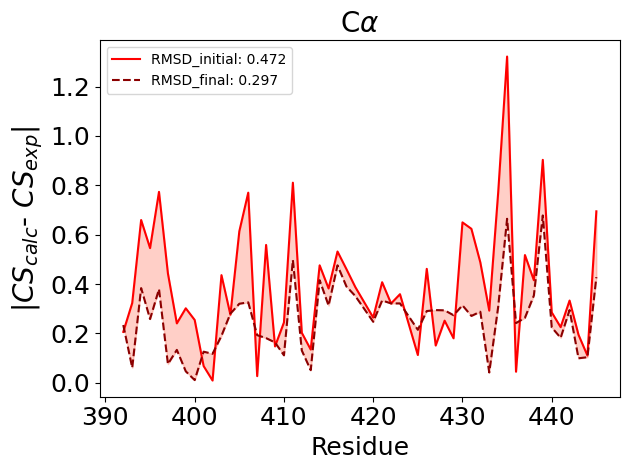

C
RMSD_initial: 0.441 RMSD_final: 0.318


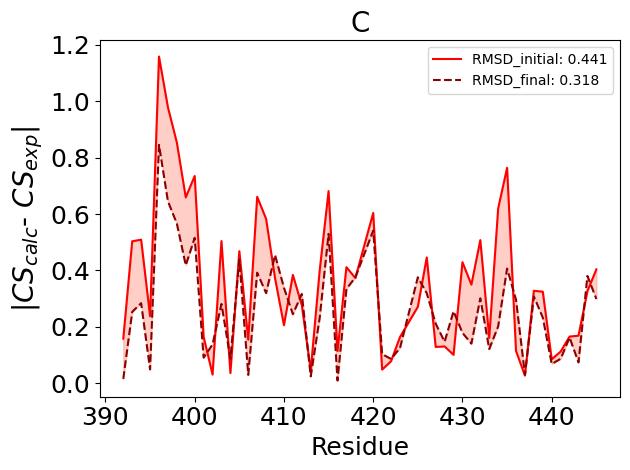

CD
RMSD_initial: 1.633 RMSD_final: 1.355


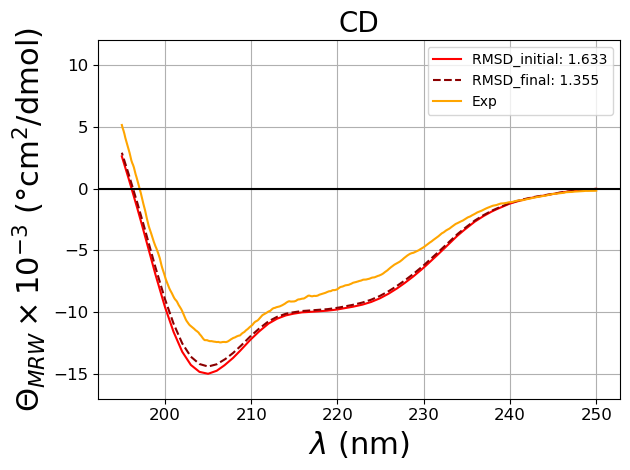

CA-C-CD Theta: 2.114210526315789 Kish: 29.186184 RMSD initail: 1.5091 RMSD final: 1.2487
Initial RMSE reweight data 
 * Total :      1.509
 *    CA :      0.472
 *     C :      0.441
 *    CD :      1.633
Final RMSE reweight data
 * Total :      1.249
 *    CA :      0.297
 *     C :      0.318
 *    CD :      1.355


In [17]:
To_Scan=combined_reweighting_keys


CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(To_Scan[0], true_exp_labels)
obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(Reweight_Data, expdata, compdata, theta_dict, sd, compare_dict_r)


s = '{:.2f}'.format(theta_m)

sigma_reg=theta_m*err_r
sigma_md=sigma_md_r
        

nobs_r = len(obs_exp_r)
nobs_v = len(obs_exp_v)
weight_bias=np.ones(nframes)
if 'RDC' in Reweight_Data:    
       initial_weights=weight_bias
       initial_weights/=np.sum(initial_weights)
       initial_obs_r=np.dot(traj_r,initial_weights)
       initial_obs_r
       exp_rdc=np.trim_zeros(obs_exp_r*data_r_type['RDC'])
       calc_rdc=np.trim_zeros(initial_obs_r*data_r_type['RDC'])
       qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos=scale_rdc_Q(exp_rdc,calc_rdc)
       #print(qi_pos,rms_i_pos,qf_pos,rms_f_pos,rdc_scale_pos,c_pos)    
       qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg=scale_rdc_Q(-exp_rdc,calc_rdc)
       #print(qi_neg,rms_i_neg,qf_neg,rms_f_neg,rdc_scale_neg,c_neg)

       if(qf_neg<qf_pos):
        c=-c_neg
       else: 
        c=c_pos
    
       RDC_rows=np.where(data_r_type['RDC']==1)
       traj_r[RDC_rows]=traj_r[RDC_rows]*c


res = sp.optimize.minimize(func_sigma_reg_sigma_md, args = (traj_r, obs_exp_r, weight_bias, sigma_reg,sigma_md), x0 =  np.zeros((nobs_r,)), method='L-BFGS-B',jac=True)
initial_weights = Normalize_Weights(weight_bias)
initial_obs_r=np.dot(traj_r,initial_weights)
final_weights = Normalize_Weights(weight_bias-np.dot(res.x,traj_r))
final_obs_r=np.dot(traj_r,final_weights)
Ks_b = np.average(initial_weights)**2/np.average(initial_weights**2)
Ks_a = np.average(final_weights)**2/np.average(final_weights**2)
        
Kish_ratio = (Ks_a/Ks_b)*100
RMSE_initial=np.sqrt(np.mean((initial_obs_r-obs_exp_r)**2))
RMSE_reweight=np.sqrt(np.mean((final_obs_r-obs_exp_r)**2))

plot_fitting_data(final_weights)
print_comb_results()

np.savetxt('%s/weights_final.dat' % (CS_dir), final_weights, fmt=" %6.12lf")
# print final weights to file

f = open("%s/weights_final.a.dat" % CS_dir, "w")
for w in final_weights:
       f.write("%e\n" % w)
f.close()

## Now let's look at how the CSP vs the CD data can influence the reweighting

We will reweight using either CSP or CD and make plots to compare, using the same sort of code as above. 

In [18]:
new_rwt_keys = [['CA', 'C'],'CD']

In [19]:
To_Scan = new_rwt_keys
thetas = np.linspace(0.01, 20, 20)
ref_theta = thetas[-1]
RMSE_leave_one_dict = {}
KishScan_leave_one_out = {}
for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
    KishScan_leave_one_out[CS] = {}
    print('Reweight Data = {}'.format(CS))
    RMSE_leave_one_dict[CS] = {}

    compare = []
    compare_dict_r = {key: {} for key in compdata.keys()}
    compare_dict_v = {key: {} for key in compdata.keys()}

    ####### B) The reweighting procedure

    obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(Reweight_Data, expdata, compdata, theta_dict, sd, compare_dict_r)
    obs_exp_v, traj_v, err_v, sigma_md_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays_with_sigma(Validation_Data, expdata, compdata, theta_0, sd, compare_dict_v)

    # THETA CYCLE
    theta_list = []
    kish_list = []
    rmsd_f_list = []
    for theta_m in np.flip(thetas):

        s = '{:.2f}'.format(theta_m)
        sigma_reg = theta_m * err_r
        sigma_md = sigma_md_r
        RMSE_leave_one_dict[CS][s] = {}

        # iv) Print dimensions
        nobs_r = len(obs_exp_r)
        nobs_v = len(obs_exp_v)
        # Print_Number_of_Data(nframes, nobs_r, nobs_v, data_r_type, data_v_type)

        # v) perform minimization
        # OBS: res.X = lagrange multiplier
        weight_bias = np.ones(nframes)

        if 'RDC' in Reweight_Data:
            initial_weights = weight_bias
            initial_weights /= np.sum(initial_weights)
            initial_obs_r = np.dot(traj_r, initial_weights)
            initial_obs_r
            exp_rdc = np.trim_zeros(obs_exp_r * data_r_type['RDC'])
            calc_rdc = np.trim_zeros(initial_obs_r * data_r_type['RDC'])
            qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
            qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

            if (qf_neg < qf_pos):
                c = -c_neg
            else:
                c = c_pos

            RDC_rows = np.where(data_r_type['RDC'] == 1)
            traj_r[RDC_rows] = traj_r[RDC_rows] * c

        if 'RDC' in Validation_Data:
            initial_weights = weight_bias
            initial_weights /= np.sum(initial_weights)
            initial_obs_v = np.dot(traj_v, initial_weights)
            exp_rdc = np.trim_zeros(obs_exp_v * data_v_type['RDC'])
            calc_rdc = np.trim_zeros(initial_obs_v * data_v_type['RDC'])
            qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
            qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

            if (qf_neg < qf_pos):
                c = -c_neg
            else:
                c = c_pos

            RDC_rows = np.where(data_v_type['RDC'] == 1)
            traj_v[RDC_rows] = traj_v[RDC_rows] * c

        res = sp.optimize.minimize(func_sigma_reg_sigma_md,
                                    args=(traj_r, obs_exp_r, weight_bias, sigma_reg, sigma_md),
                                    x0=np.zeros((nobs_r,)), method='L-BFGS-B', jac=True)
        initial_weights = Normalize_Weights(weight_bias)
        initial_obs_r = np.dot(traj_r, initial_weights)
        initial_obs_v = np.dot(traj_v, initial_weights)

        final_weights = Normalize_Weights(weight_bias - np.dot(res.x, traj_r))
        final_obs_r = np.dot(traj_r, final_weights)
        final_obs_v = np.dot(traj_v, final_weights)
        # g) calculating Kish effective size
        Ks_b = np.average(initial_weights) ** 2 / np.average(initial_weights ** 2)
        Ks_a = np.average(final_weights) ** 2 / np.average(final_weights ** 2)

        Kish_ratio = (Ks_a / Ks_b) * 100
        RMSE_initial = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))
        RMSE_reweight = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))

        theta_list.append(theta_m)
        kish_list.append(Kish_ratio)
        rmsd_f_list.append(RMSE_reweight)
        RMSE_r_i = {}
        RMSE_v_i = {}
        RMSE_r_f = {}
        RMSE_v_f = {}
        RMSE_r_i['Tot'] = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))

        for t in data_r_type:
            RMSE_r_i[t] = np.sqrt(
                np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
            if str(t) == 'RDC':
                qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
                                                                    obs_exp_r * data_r_type['RDC'])
                RMSE_r_i['RDC'] = qf

        RMSE_v_i['Tot'] = np.sqrt(
            np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
        for t in data_v_type:
            RMSE_v_i[t] = np.sqrt(
                np.sum((initial_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t]))
            if str(t) == 'RDC':
                qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_v * data_v_type['RDC'],
                                                                    obs_exp_v * data_v_type['RDC'])
                RMSE_v_i['RDC'] = qf

        RMSE_r_f['Tot'] = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))

        for t in data_r_type:
            RMSE_r_f[t] = np.sqrt(np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t]))
            if str(t) == 'RDC':
                qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
                                                                    obs_exp_r * data_r_type['RDC'])
                RMSE_r_f['RDC'] = qf

        for t in data_v_type:
            RMSE_v_f[t] = np.sqrt(np.sum((final_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t]))
            if str(t) == 'RDC':
                qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(final_obs_v * data_v_type['RDC'],
                                                                    obs_exp_v * data_v_type['RDC'])
                RMSE_v_f['RDC'] = qf

        RMSE_leave_one_dict[CS][s]['Kish'] = Kish_ratio
        RMSE_leave_one_dict[CS][s]['r_i'] = RMSE_r_i
        RMSE_leave_one_dict[CS][s]['r_f'] = RMSE_r_f
        RMSE_leave_one_dict[CS][s]['v_i'] = RMSE_v_i
        RMSE_leave_one_dict[CS][s]['v_f'] = RMSE_v_f

    KishScan_leave_one_out[CS]['kish'] = np.column_stack((theta_list, kish_list))
    KishScan_leave_one_out[CS]['rmsd'] = np.column_stack((theta_list, rmsd_f_list))

Reweight Data = CA-C
Reweight Data = CD


In [20]:
kish_min = 10
theta_dict_leave_one = {}
Kish_ratio_vals = []
for key in KishScan_leave_one_out:
    k = KishScan_leave_one_out[key]['kish']
    b = (np.where(k[:, 1] >= kish_min))[0]
    idx = b[-1]
    idy = b[-2]
    theta_m = k[idx][0]
    Kish_ratio_vals.append(theta_m)
    if (theta_m == 0):
        theta_m = k[idy][0]
    theta_dict_leave_one[key] = {}
    theta_dict_leave_one[key] = (theta_m)

In [21]:
validation_dir = '/Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Final_Project/Alanine_Mutant/validation_images/'
if not os.path.exists(validation_dir):
    os.makedirs(validation_dir)

In [22]:
# again defining a function that can plot the different CD and CA/C' reweighting effects

def plot_fitting_validate_data(weights):
    for t in Reweight_Data:
        if t != 'Rg':
            print(t)
            resid = []
            exp = []
            calc = []
            for i, id in enumerate(compare_dict_r[t]):
                resid.append(float(id))
                exp.append(compare_dict_r[t][id][0])
                
            initial = np.trim_zeros(initial_obs_r * data_r_type[t])
            reweight = np.trim_zeros(final_obs_r * data_r_type[t])
            exp = np.trim_zeros(obs_exp_r * data_r_type[t])
            
            rmsd_i = (sum(np.square(initial - exp)) / len(exp)) ** 0.5
            rmsd_f = (sum(np.square(reweight - exp)) / len(exp)) ** 0.5
            print("RMSD_initial:%6.3lf" % rmsd_i, "RMSD_final:%6.3lf" % rmsd_f)
            plt.clf()


            if t == 'CA':
                plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$CS_{calc}$- $CS_{exp}$|', size=20)
                plt.title(r"C$\alpha$ restraint" , size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.xlabel('Residue', size=18)
                plt.legend(loc='best')
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.pdf' % (validation_dir, t), bbox_inches='tight')
                plt.show()

            elif t == 'CD':
                
                plt.plot(np.asarray(resid), initial, color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), reweight, color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.plot(exp_CD[:,0], exp_CD[:,1], color='orange', label='Exp')
                
                plt.axhline(y=0, color='black')
                plt.legend(fontsize=15)
                plt.xlabel(r"$\lambda$ (nm)", size=22)
                plt.ylabel(r"$\Theta_{MRW} \times 10^{-3}$ (°cm$^2$/dmol)", size=22)
                plt.title('%s restraint' % t, size='20')
                plt.xticks(size='12')
                plt.yticks(size='12')
                plt.grid()
                plt.legend(loc='best')
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.pdf' % (validation_dir, t), bbox_inches='tight')
                plt.show()

                


            else:
                plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$CS_{calc}$- $CS_{exp}$|', size=20)
                plt.title('%s restraint' % t, size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.xlabel('Residue', size=18)
                plt.legend(loc='best')
                plt.tight_layout()
                plt.savefig('%s/%s.reweight.dev.pdf' % (validation_dir, t), bbox_inches='tight')
                plt.show()
                
    for t in Validation_Data:
        if t != 'Rg':
            print(t)
            resid = []
            exp = []
            calc = []
            for i, id in enumerate(compare_dict_v[t]):
                resid.append(float(id))
                exp.append(compare_dict_v[t][id][0])
                
            initial = np.trim_zeros(initial_obs_v * data_v_type[t])
            reweight = np.trim_zeros(final_obs_v * data_v_type[t])
            exp = np.trim_zeros(obs_exp_v * data_v_type[t])
            
            rmsd_i = (sum(np.square(initial - exp)) / len(exp)) ** 0.5
            rmsd_f = (sum(np.square(reweight - exp)) / len(exp)) ** 0.5
            print("RMSD_initial:%6.3lf" % rmsd_i, "RMSD_final:%6.3lf" % rmsd_f)
            plt.clf()


            if t == 'CA':
                plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$CS_{calc}$- $CS_{exp}$|', size=20)
                plt.title(r"C$\alpha$ validation", size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.xlabel('Residue', size=18)
                plt.legend(loc='best')
                plt.tight_layout()
                plt.savefig('%s/%s.validation.dev.pdf' % (validation_dir, t), bbox_inches='tight')
                plt.show()

            elif t == 'CD':
                
                plt.plot(np.asarray(resid), initial, color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), reweight, color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.plot(exp_CD[:,0], exp_CD[:,1], color='orange', label='Exp')
                
                plt.axhline(y=0, color='black')
                plt.legend(fontsize=15)
                plt.xlabel(r"$\lambda$ (nm)", size=22)
                plt.ylabel(r"$\Theta_{MRW} \times 10^{-3}$ (°cm$^2$/dmol)", size=22)
                plt.title('%s validation' % t, size='20')
                plt.xticks(size='12')
                plt.yticks(size='12')
                plt.grid()
                plt.legend(loc='best')
                plt.tight_layout()
                plt.savefig('%s/%s.validation.dev.pdf' % (validation_dir, t), bbox_inches='tight')
                plt.show()

                


            else:
                plt.plot(np.asarray(resid), np.absolute(initial - exp), color='red',
                         label="RMSD_initial:%6.3lf" % rmsd_i)
                plt.plot(np.asarray(resid), np.absolute(reweight - exp), color='darkred', linestyle='dashed',
                         label="RMSD_final:%6.3lf" % rmsd_f)
                plt.fill_between(np.asarray(resid), np.absolute(reweight - exp), np.absolute(initial - exp),
                                 color='tomato', alpha=0.3)
                plt.ylabel(r'|$CS_{calc}$- $CS_{exp}$|', size=20)
                plt.title('%s validation' % t, size='20')
                plt.xticks(fontsize=16)
                plt.yticks(fontsize=16)
                plt.xticks(size='18')
                plt.yticks(size='18')
                plt.xlabel('Residue', size=18)
                plt.legend(loc='best')
                plt.tight_layout()
                plt.savefig('%s/%s.validation.dev.pdf' % (validation_dir, t), bbox_inches='tight')
                plt.show()

**The first three plots below are those generated after reweighting with CA/C' and using CD as validation. The last three plots are after reweighting with CD and using CSP data as validation.**

Reweight Data = CA-C
2.11
CA
RMSD_initial: 0.472 RMSD_final: 0.301


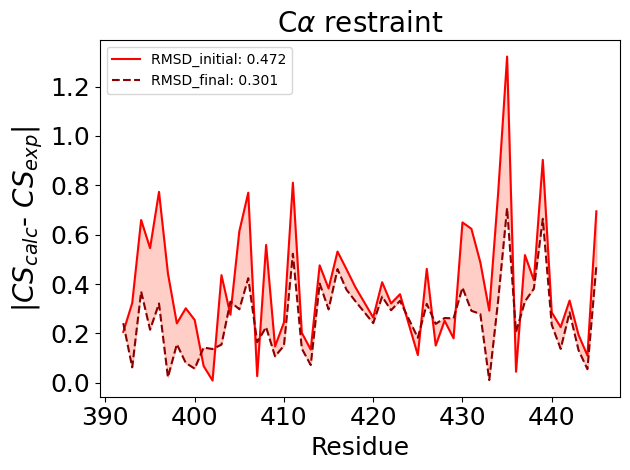

C
RMSD_initial: 0.441 RMSD_final: 0.310


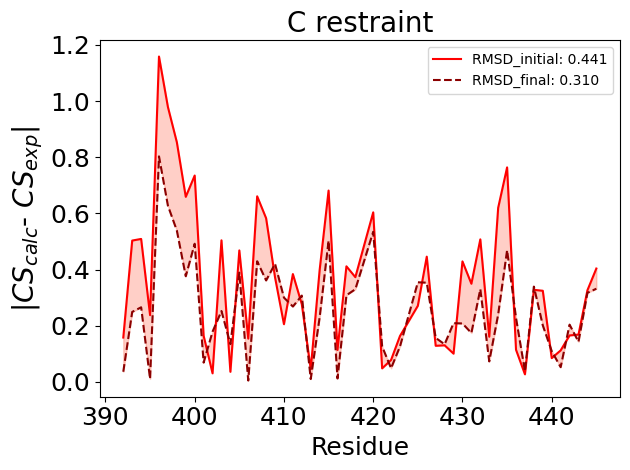

CD
RMSD_initial: 1.633 RMSD_final: 1.625


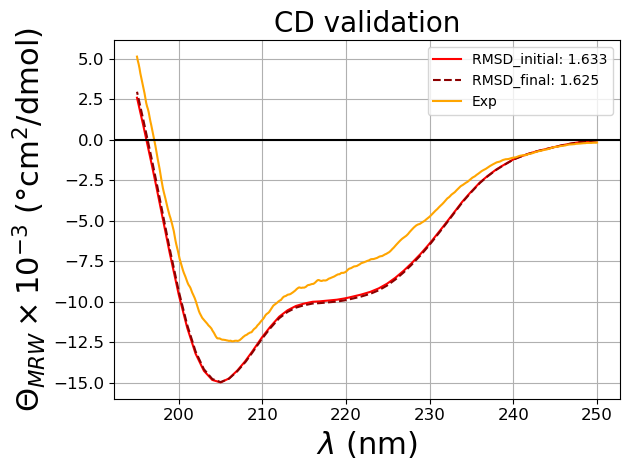

CA-C Theta: 2.114210526315789 Kish: 40.076403 RMSD initail: 0.4565 RMSD final: 0.3056
Initial RMSE reweight data 
 * Total :      0.457
 *    CA :      0.472
 *     C :      0.441
Initial RMSE validation data
 * Total :      1.633
 *    CD :      1.633
Final RMSE reweight data
 * Total :      0.306
 *    CA :      0.301
 *     C :      0.310
Final RMSE validation data
 * Total :      1.625
 *    CD :      1.625
Reweight Data = CD
1.06
CD
RMSD_initial: 1.633 RMSD_final: 0.809


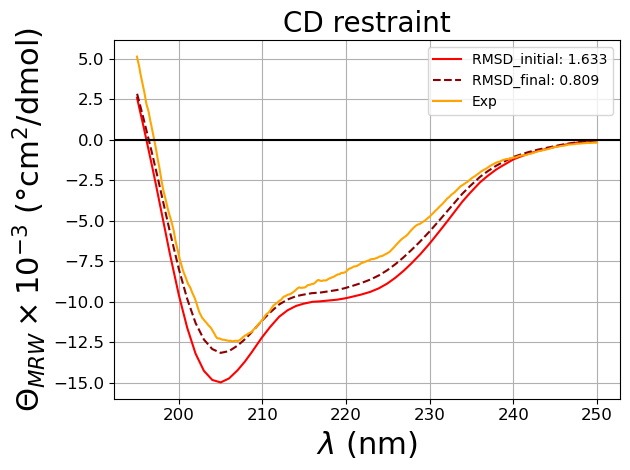

CA
RMSD_initial: 0.472 RMSD_final: 0.472


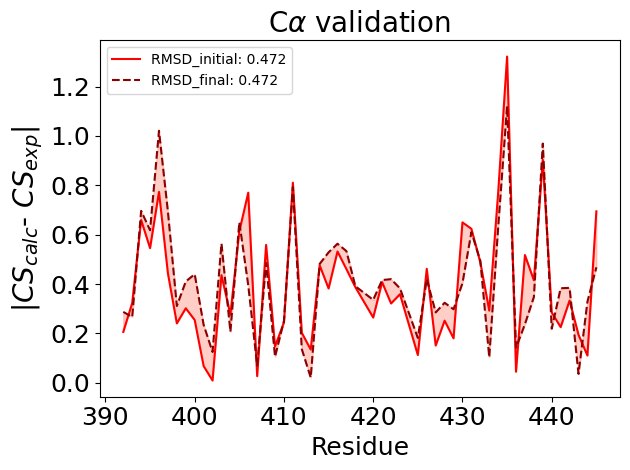

C
RMSD_initial: 0.441 RMSD_final: 0.484


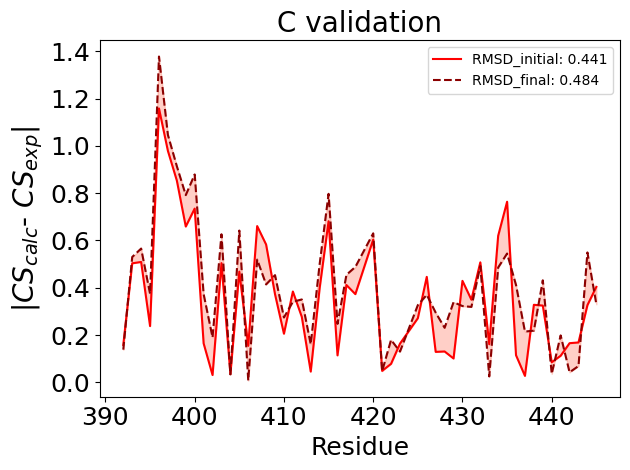

CD Theta: 1.0621052631578947 Kish: 11.788715 RMSD initail: 1.6334 RMSD final: 0.8094
Initial RMSE reweight data 
 * Total :      1.633
 *    CD :      1.633
Initial RMSE validation data
 * Total :      0.457
 *    CA :      0.472
 *     C :      0.441
Final RMSE reweight data
 * Total :      0.809
 *    CD :      0.809
Final RMSE validation data
 * Total :      0.478
 *    CA :      0.472
 *     C :      0.484


In [23]:
To_Scan = new_rwt_keys

for CS in To_Scan:
    CS, Reweight_Data, Validation_Data = Separate_Validation_Reweighting_Data(CS, true_exp_labels)
    print('Reweight Data = {}'.format(CS))
    CS_dir = join(leave_dir, CS)
    if not os.path.exists(CS_dir):
        os.makedirs(CS_dir)

    compare = []
    compare_dict_r = {key: {} for key in compdata.keys()}
    compare_dict_v = {key: {} for key in compdata.keys()}

    obs_exp_r, traj_r, err_r, sigma_md_r, data_r_t, data_r_type, compare_dict_r = Process_Data_Into_Arrays_with_sigma(
        Reweight_Data, expdata, compdata, theta_dict, sd, compare_dict_r)
    obs_exp_v, traj_v, err_v, sigma_md_v, data_v_t, data_v_type, compare_dict_v = Process_Data_Into_Arrays_with_sigma(
        Validation_Data, expdata, compdata, theta_0, sd, compare_dict_v)

    theta_m = theta_dict_leave_one[CS]
    s = '{:.2f}'.format(theta_m)
    print(s)
    sigma_reg = theta_m * err_r
    sigma_md = sigma_md_r

    # iv) Print dimensions
    nobs_r = len(obs_exp_r)
    nobs_v = len(obs_exp_v)

    # v) perform minimization
    # OBS: res.X = lagrange multiplier
    weight_bias = np.ones(nframes)
    if 'RDC' in Reweight_Data:
        intial_weights = weight_bias
        initial_weights /= np.sum(initial_weights)
        initial_obs_r = np.dot(traj_r, initial_weights)
        initial_obs_r
        exp_rdc = np.trim_zeros(obs_exp_r * data_r_type['RDC'])
        calc_rdc = np.trim_zeros(initial_obs_r * data_r_type['RDC'])
        qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
        qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

        if (qf_neg < qf_pos):
            c = -c_neg
        else:
            c = c_pos
        RDC_rows = np.where(data_r_type['RDC'] == 1)
        traj_r[RDC_rows] = traj_r[RDC_rows] * c

    if 'RDC' in Validation_Data:
        intial_weights = weight_bias
        initial_weights /= np.sum(initial_weights)
        initial_obs_v = np.dot(traj_v, initial_weights)
        initial_obs_v
        exp_rdc = np.trim_zeros(obs_exp_v * data_v_type['RDC'])
        calc_rdc = np.trim_zeros(initial_obs_v * data_v_type['RDC'])
        qi_pos, rms_i_pos, qf_pos, rms_f_pos, rdc_scale_pos, c_pos = scale_rdc_Q(exp_rdc, calc_rdc)
        qi_neg, rms_i_neg, qf_neg, rms_f_neg, rdc_scale_neg, c_neg = scale_rdc_Q(-exp_rdc, calc_rdc)

        if (qf_neg < qf_pos):
            c = -c_neg
        else:
            c = c_pos
        RDC_rows = np.where(data_v_type['RDC'] == 1)
        traj_v[RDC_rows] = traj_v[RDC_rows] * c

    res = sp.optimize.minimize(func_sigma_reg_sigma_md, args=(traj_r, obs_exp_r, weight_bias, sigma_reg, sigma_md),
                                x0=np.zeros((nobs_r,)), method='L-BFGS-B', jac=True)
    initial_weights = Normalize_Weights(weight_bias)
    initial_obs_r = np.dot(traj_r, initial_weights)
    initial_obs_v = np.dot(traj_v, initial_weights)
    # if res.success: print("\nMinimization worked: {}\n".format(res.success))
    # else: raise ValueError('Minimization with {}, theta = {} as reweighting data did not worked!'.format(CS, s))
    final_weights = Normalize_Weights(weight_bias - np.dot(res.x, traj_r))
    # e) final average observables for reweighting and validation
    final_obs_r = np.dot(traj_r, final_weights)
    final_obs_v = np.dot(traj_v, final_weights)
    # g) calculating Kish effective size
    Ks_b = np.average(initial_weights) ** 2 / np.average(initial_weights ** 2)
    Ks_a = np.average(final_weights) ** 2 / np.average(final_weights ** 2)
    # print("Initial Kish size : %9.6lf %d" % (Ks_b, Ks_b*nframes))
    # print("Reweighted Kish size : %9.6lf %d" % (Ks_a, Ks_a*nframes))
    Kish_ratio = (Ks_a / Ks_b) * 100
    RMSE_initial = np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2))
    RMSE_reweight = np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2))

    plot_fitting_validate_data(final_weights)
    
    print(CS, "Theta:", theta_m, "Kish: %9.6lf" % (Kish_ratio), "RMSD initail: %0.4f" % RMSE_initial,
            "RMSD final: %0.4f" % RMSE_reweight)

    print("Initial RMSE reweight data ")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_r - obs_exp_r) ** 2)))

    for t in data_r_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(
            np.sum((initial_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))

        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_r * data_r_type['RDC'],
                                                                obs_exp_r * data_r_type['RDC'])
            # print(" *    RDC scaled RMSD:", end = '')
            # print(" %6.3lf" % rms_f)
            print(" *    RDC scaled Q:", end='')
            print(" %6.3lf" % qf)

    print("Initial RMSE validation data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((initial_obs_v - obs_exp_v) ** 2)))

    for t in data_v_type:
        print(" *    %2s :" % t, end='')
        # (initial_obs_v-obs_exp_v)**2*data_v_type[t])
        print("     %6.3lf" % np.sqrt(
            np.sum((initial_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_i, c = scale_rdc_Q(initial_obs_v * data_v_type['RDC'],
                                                                obs_exp_v * data_v_type['RDC'])
            # print(" *    RDC scaled RMSD:", end = '')
            # print(" %6.3lf" % rms_f)
            print(" *    RDC scaled Q:", end='')
            print(" %6.3lf" % qf)

    print("Final RMSE reweight data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_r - obs_exp_r) ** 2)))

    for t in data_r_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(
            np.sum((final_obs_r - obs_exp_r) ** 2 * data_r_type[t]) / np.sum(data_r_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdcs_scale_f, c = scale_rdc_Q(final_obs_r * data_r_type['RDC'],
                                                                obs_exp_r * data_r_type['RDC'])
            # print(" *    RDC RMSE_scale:", end = '')
            # print(" %6.3lf" % rms_f)
            print(" *    RDC Q_scaled:", end='')
            print(" %6.3lf" % qf)

    print("Final RMSE validation data")
    print(" * Total :     %6.3lf" % np.sqrt(np.mean((final_obs_v - obs_exp_v) ** 2)))

    for t in data_v_type:
        print(" *    %2s :" % t, end='')
        print("     %6.3lf" % np.sqrt(
            np.sum((final_obs_v - obs_exp_v) ** 2 * data_v_type[t]) / np.sum(data_v_type[t])))
        if str(t) == 'RDC':
            qi, rms_i, qf, rms_f, rdc_scale_f, c = scale_rdc_Q(final_obs_v * data_v_type['RDC'],
                                                                obs_exp_v * data_v_type['RDC'])
            # print(" *    RDC RMSE_scale:", end = '')
            # print(" %6.3lf" % rms_f)
            print(" *    RDC Q_scaled:", end='')
            print(" %6.3lf" % qf)
    np.savetxt('%s/weights_final.dat' % (CS_dir), final_weights, fmt=" %6.12lf")
    # print final weights to file

    f = open("%s/weights_final.a.dat" % CS_dir, "w")
    for w in final_weights:
        f.write("%e\n" % w)
    f.close()